<a href="https://colab.research.google.com/github/sahushivam/MachineLearning/blob/master/Colab/Copy_of_indic2019_east_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import statement

In [0]:
#!pip install tensorflow==1.13.1

In [1]:
import tensorflow as tf
from keras import backend as K
from google.colab import drive
drive.mount('/gdrive')
import os
import re
import shutil
import tarfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import IPython.display as display
import tensorboardcolab as tbc
tbc = tbc.TensorBoardColab()

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
Wait for 8 seconds...
TensorBoard link:
https://9901ab09.ngrok.io


Write in tensorflow 

In [2]:
writer = tbc.get_writer()

W0715 08:12:50.097071 140187324671872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Defining the variables

In [0]:
batch_size = 10
nb_boxes=1
grid_w=2
grid_h=2
cell_w=14
cell_h=14
img_w=28
img_h=28
img_channels = 1
input_shape = (None, img_w, img_h, img_channels)

Extract function takes data record and return images and data

In [0]:
def extract_fn(data_record):
    features = {
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([5], tf.float32)
    }
    data = tf.parse_single_example(data_record, features)
    img1 = tf.decode_raw(data['image'], tf.float32)
    img1 = tf.reshape(img1, (img_w, img_h, img_channels)) #reshape to 28 x 28 x 1
    img1 = tf.image.per_image_standardization(img1) #Standardizing
    return img1, data['label']

In [0]:
files_pattern = '/gdrive/My Drive/indic2019/TFRecords/*.tfrecord' #file pattern for tf record
test_pattern = '/gdrive/My Drive/indic2019/Test/*.tfrecord' #file pattern for testing it on the test pattern
test_image = '/gdrive/My Drive/indic2019/images/10_10.jpg'

<h3> Input function</h3>
  <ul>
    <li>Input parameters are files pattern(for taking data from the input), batch_size and mode(predict,eval and train)</li>
  <li>Returns features and label in case of eval and train and features in case of predict</li>
    </ul>


In [0]:
def input_fn(files_pattern,batch_size, mode):
  print(batch_size)
  files = tf.data.Dataset.list_files(files_pattern, shuffle=True)
  dataset = files.apply(tf.contrib.data.parallel_interleave( lambda filename: tf.data.TFRecordDataset(filename), cycle_length=1)) 
  #T parallel_interleave-HIS FUNCTION IS DEPRECATED. (not exactly know)
    
  #three variables for three mode
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  is_eval = (mode == tf.estimator.ModeKeys.EVAL)
  is_predict = (mode== tf.estimator.ModeKeys.PREDICT)
  
  buffer_size = batch_size * 2 + 1
  dataset = dataset.shuffle(buffer_size=buffer_size)

  # Transformation
  dataset = dataset.map(extract_fn)
  
  if is_training or is_predict:
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2 * batch_size)
    
  if is_eval:
    buffer_size = batch_size * 10
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10 * batch_size)

  image, label = dataset.make_one_shot_iterator().get_next()
  features = {'images': image}
  
  if is_training or is_eval:
    return features, label
  
  if is_predict:
    return features 

<h3> Custom loss </h3>

In [0]:

def custom_loss(labels,logits):
  
  print(logits)
  
  true_confidence = labels[:,0]
  true_x=labels[:,1]
  true_y=labels[:,2]
  true_w=labels[:,3]
  true_h=labels[:,4]

  predict_confidence=logits[:,0]
  predict_x=logits[:,1]
  predict_y=logits[:,2]
  predict_w=logits[:,3]
  predict_h=logits[:,4]	

  xy_loss= K.square(true_x-predict_x) + K.square(true_y-predict_y)
  wh_loss= K.square(K.sqrt(true_w)-K.sqrt(predict_w))+ K.square(K.sqrt(true_h)-K.sqrt(predict_h))

  con_loss=K.square(true_confidence-predict_confidence)

  loss= xy_loss + wh_loss + con_loss
  return tf.math.reduce_mean(loss)

**Loss function as given in east implementation**


In [0]:
def class_classification(true_class, pred_class,
                     training_mask=1):
    eps = 1e-5
    intersection = tf.reduce_sum(true_class * pred_class * training_mask)
    union = tf.reduce_sum(true_class * training_mask) + tf.reduce_sum(pred_class * training_mask) + eps
    loss = 1. - (2 * intersection / union)
    tf.summary.scalar('classification_loss', loss)
    return loss

In [0]:
def loss(labels,logits,training_mask):

    true_class=labels[:,0]
    classification_loss = class_classification(true_class, pred_class, training_mask)
    # scale classification loss to match the iou loss part
    classification_loss *= 0.01

    # d1 -> top, d2->right, d3->bottom, d4->left
    d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=true_bound, num_or_size_splits=5, axis=3)
    d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=pred_bound, num_or_size_splits=5, axis=3)
    area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
    area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
    w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
    h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
    area_intersect = w_union * h_union
    area_union = area_gt + area_pred - area_intersect
    L_AABB = -tf.log((area_intersect + 1.0)/(area_union + 1.0))
    L_theta = 1 - tf.cos(theta_pred - theta_gt)
    tf.summary.scalar('geometry_AABB', tf.reduce_mean(L_AABB * true_class * training_mask))
    tf.summary.scalar('geometry_theta', tf.reduce_mean(L_theta * true_class * training_mask))
    L_g = L_AABB + 20 * L_theta

    return tf.reduce_mean(L_g * true_class * training_mask) + classification_loss

<h3>Bounding Box</h3>
Returns coordinates of bounding box

In [0]:
#Shape of y : conf x y w h

def convert_to_coord(y):
  coord= []
  bb_box_width = y[:,3] * img_w
  bb_box_height = y[:,4] * img_h
  center_x = y[:,1] * img_w
  center_y = y[:,2] * img_h
  coord.append((center_x - (bb_box_width / 2)))
  coord.append((center_y - (bb_box_height / 2)))
  coord.append((center_x + (bb_box_width / 2)))
  coord.append((center_y + (bb_box_height / 2)))
  
  return coord
  

<h3>IOU Loss</h3>

In [0]:

def iou_loss(labels,logits):
  #Convert the arrays to absolute coordinates
  coord_labels = convert_to_coord(labels)
  coord_logits = convert_to_coord(logits)
  
  # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2.Calculate its Area.
  xi1 = tf.math.maximum((coord_labels[0]), (coord_logits[0]))
  yi1 = tf.math.maximum((coord_labels[1]), (coord_logits[1]))
  xi2 = tf.math.minimum((coord_labels[2]), (coord_logits[2]))
  yi2 = tf.math.minimum((coord_labels[3]), (coord_logits[3]))
  inter_area = tf.math.maximum((yi2-yi1), 0) * tf.math.maximum((xi2-xi1), 0)
  
  # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
  box1_area = (coord_labels[3] - coord_labels[1])*(coord_labels[2]- coord_labels[0])
  box2_area = (coord_logits[3] - coord_logits[1])*(coord_logits[2]- coord_logits[0])
  union_area = (box1_area + box2_area) - inter_area
  # compute the IoU
  
  iou =inter_area / union_area

  return iou
  

<h3>Feature Columns</h3>
The feature columns is an intermediaries between raw data and Estimators.<br/>
Feature columns bridge raw data with the data your model needs.


In [0]:
def get_feature_columns():
  feature_columns = {'images': tf.feature_column.numeric_column('images', (28, 28, 1))}
  return feature_columns

**Unpool used in Base Model**

In [0]:
def unpool(inputs):
    return tf.image.resize_bilinear(inputs, size=[tf.shape(inputs)[1]*2,  tf.shape(inputs)[2]*2])

<h3>Base Model</h3>

In [0]:
def base_model(input,batch_size, input_shape):
  
  #print(input.shape)
  #print(batch_size)
  
  #tf.name_scope()
  #Conv Layer - 1
  #Input is 28*28 and with kernal size= 5*5 and 16 filters it is reduced to 28-5+1= 24*24
  with tf.name_scope('Conv_s_4') as scope:
    x_s_4 = tf.keras.layers.Conv2D(16,(5,5), input_shape = input_shape , name="Conv_4",
                             use_bias=True, kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros')(input)
    x_s_4 = tf.keras.layers.BatchNormalization()(x_s_4)
    x_s_4 = tf.keras.layers.ReLU()(x_s_4)
    unpooled_output_4=x_s_4
    x_s_4= tf.keras.layers.MaxPooling2D()(x_s_4) 
    
    output_4 = x_s_4
    print("output_4")
    print(output_4)

  with tf.name_scope('Conv_s_3') as scope:
    x_s_3 = tf.keras.layers.Conv2D(16,(5,5), name="Conv_3",
                             use_bias=True, kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros')(x_s_4)
    x_s_3 = tf.keras.layers.BatchNormalization()(x_s_3)
    x_s_3 = tf.keras.layers.ReLU()(x_s_3)
    unpooled_output_3=x_s_3
    #x= tf.keras.layers.MaxPooling2D()(x)
  
    output_3 = x_s_3
  print("output_3")
  print(output_3)
  
  with tf.name_scope('Conv_s_2') as scope:
    x_s_2 = tf.keras.layers.Conv2D(16,(5,5), name="Conv_2",
                             use_bias=True, kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros')(x_s_3)
    x_s_2 = tf.keras.layers.BatchNormalization()(x_s_2)
    x_s_2 = tf.keras.layers.ReLU()(x_s_2)
    unpooled_output_2=x_s_2
    #x= tf.keras.layers.MaxPooling2D()(x)
    
  output_2 = x_s_2
  print("output_2")
  print(output_2)
  
  with tf.name_scope('Conv_s_1') as scope:
    x_s_1 = tf.keras.layers.Conv2D(16,(1,1), name="Conv_1",
                             use_bias=True, kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros')(x_s_2)
    x_s_1 = tf.keras.layers.BatchNormalization()(x_s_1)
    x_s_1 = tf.keras.layers.ReLU()(x_s_1)
  
  unpooled_output_1=x_s_1
  print('Printing Output 1')
  print(unpooled_output_1)
  
  #first stack layer ends we have all the unpooled layer of conv2D(4,3,2,1) 
  #named unpooled_output_4,unpooled_output_3,unpooled_output_2,unpooled_output_1
  with tf.name_scope('feature_merging_branch') as scope:
    output_1_resized = tf.image.resize_bilinear(unpooled_output_1, size=[4, 4])
    print('outut_1_resized bilinear')
    print(output_1_resized)

    y = tf.keras.layers.concatenate([output_2,output_1_resized], axis=3)
    print('Concatenation of output_2 and output_1_resized')
    print(y)
    with tf.name_scope('Conv_5_0') as scope:
      y5 = tf.keras.layers.Conv2D(16,(1,1), name="Conv_5_0",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y)
      y5 = tf.keras.layers.BatchNormalization()(y5)
      y5 = tf.keras.layers.ReLU()(y5)
    
    with tf.name_scope('Conv_5_1') as scope:
      y5_1 = tf.keras.layers.Conv2D(16,(3,3), name="Conv_5_1",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y5)
      y5_1 = tf.keras.layers.BatchNormalization()(y5_1)
      y5_1 = tf.keras.layers.ReLU()(y5_1)
      print(y5_1)
      
      output_3_resized = tf.image.resize_bilinear(unpooled_output_3, size=[2, 2])
      print("output_3_resized")
      print(output_3_resized)
    #now we have to built another conv2D which will concatenate y5_1 and unpooled_output_3
    
    with tf.name_scope('Conv_6_0') as scope:
      y6 = tf.keras.layers.concatenate([y5_1,output_3_resized], axis=3)
      y6 = tf.keras.layers.Conv2D(16,(1,1), name="Conv_6_0",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y6)
      y6 = tf.keras.layers.BatchNormalization()(y6)
      y6 = tf.keras.layers.ReLU()(y6)
    
    #instead of 1*1 kernal size we needed 3*3 kernal size but as it making the dimension negative I have used 1*1 kernal size
    with tf.name_scope('Conv_6_1') as scope:
      y6_1 = tf.keras.layers.Conv2D(16,(1,1), name="Conv_6_1",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y6)
      y6_1 = tf.keras.layers.BatchNormalization()(y6_1)
      y6_1 = tf.keras.layers.ReLU()(y6_1)
      print(y6_1)
      
    #now we have to built another conv2D which will concatenate y6_1(size is 2*2*16) and unpooled_output_4(size is 12*12*16)
    with tf.name_scope('Conv_7_0') as scope:
      output_4_resized = tf.image.resize_bilinear(unpooled_output_4, size=[2, 2])
      y7 = tf.keras.layers.concatenate([y6_1,output_4_resized], axis=3)
      y7 = tf.keras.layers.Conv2D(16,(1,1), name="Conv_7_0",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y7)
      y7 = tf.keras.layers.BatchNormalization()(y7)
      y7 = tf.keras.layers.ReLU()(y7)
    #instead of 1*1 kernal size we needed 3*3 kernal size but as it making the dimension negative I have used 1*1 kernal size
    with tf.name_scope('Conv_7_1') as scope:
      y7_1 = tf.keras.layers.Conv2D(16,(1,1), name="Conv_7_1",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y7)
      y7_1 = tf.keras.layers.BatchNormalization()(y7_1)
      y7_1 = tf.keras.layers.ReLU()(y7_1)
      print(y7_1)
      
    y = tf.keras.layers.Conv2D(16,(1,1), name="Conv_8",
                               use_bias=True, kernel_initializer='glorot_uniform', 
                               bias_initializer='zeros')(y7_1)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.ReLU()(y)
    
    
  
  #print(x)
  
  #Flatten it out
  y = tf.keras.layers.Flatten(name="Flatten_1")(y)
  #print("After flatten")
  #print(x)
  
  #Dense layer
  y = tf.keras.layers.Dense(16, activation="sigmoid", name="Dense1")(y)
  #print(x)
  y = tf.keras.layers.Dense(5, activation='sigmoid')(y)
  #print(x)
  # x = tf.keras.layers.Reshape((2*2, (1*5)), name= 'model_final_reshape')(x)
  
  return y

<h3>Model Function</h3>
<ul>
  <li>input is features, labels, mode and parameters</li>
</ul>



In [0]:
def model_fn(features, labels, mode):
                                                                                                
  feature_columns = list(get_feature_columns().values())
  images = tf.feature_column.input_layer(features=features, feature_columns=feature_columns)
  images = tf.reshape(images, shape=(-1, 28, 28, 1),name='my_reshape')


  # Calculate logits through CNN                                                                                                            
  logits = base_model(images,batch_size, input_shape)

  # Create the input layers from the features 
  if mode in (tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL):
    global_step = tf.train.get_or_create_global_step()#create default graph
    loss=custom_loss(labels,logits) #loss 
    iou = iou_loss(labels,logits) 
    tf.summary.scalar('IOU', tf.math.reduce_mean(iou))
    tf.summary.scalar('Loss', loss)

  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {'coordinates': logits}
    export_outputs = {'coordinates': tf.estimator.export.PredictOutput(predictions)}
    return tf.estimator.EstimatorSpec(mode, predictions=predictions, export_outputs=export_outputs)
  
  if mode == tf.estimator.ModeKeys.EVAL:
    iou = iou_loss(labels,logits)
    eval_metric_ops = {'iou_eval': tf.metrics.mean(iou)}
    return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False,name='Adam')
    train_op = optimizer.minimize(loss, global_step=global_step)
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
  

Preprocess is used in serving_input_fn

In [0]:
def preprocess(filename):
    # decode the image file starting from the filename
    image_contents = tf.read_file(filename)
    img_decoded = tf.image.decode_jpeg(image_contents, channels=img_channels)
    image = tf.image.convert_image_dtype(img_decoded, dtype=tf.float32) # 0-1
    img_expanded = tf.expand_dims(image, 0)
    img_resize = tf.image.resize_bilinear(img_expanded,(img_w, img_h))
    img_squeezed = tf.squeeze(img_resize,0)
    img_standardized = tf.image.per_image_standardization(img_squeezed)
    img_expanded = tf.expand_dims(img_standardized, 0)
    image= tf.reshape(img_expanded, (-1, img_w, img_h, img_channels), name='serve_reshape')
    return image

def serving_input_fn():
  #()code to read the image from url
  receiver_tensor = {'image_bytes': tf.placeholder(dtype=tf.string, shape=[1])}
  image = (receiver_tensor['image_bytes'])[0]
  img_expanded = preprocess(image)
  # make the outer dimension unknown (and not 1)
  image = tf.placeholder_with_default(img_expanded, shape=[None, img_w, img_h, img_channels])
  features = {'images': image}
  return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

In [0]:
run_config = tf.estimator.RunConfig(model_dir='./Graph6', save_summary_steps=10, save_checkpoints_secs = 300, keep_checkpoint_max = 5)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)

# There is another Exporter named FinalExporter which exports the serving graph and checkpoints at the end.

exporter = tf.estimator.LatestExporter(
  name='Serve',
  serving_input_receiver_fn=serving_input_fn,
  assets_extra=None,
  as_text=False,
  exports_to_keep=5)

train_spec = tf.estimator.TrainSpec(input_fn= lambda:input_fn(files_pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN))

eval_spec = tf.estimator.EvalSpec(lambda: input_fn(files_pattern,  batch_size , mode=tf.estimator.ModeKeys.EVAL), exporters=exporter)

In [0]:
writer.add_graph(tf.get_default_graph())
writer.flush()

In [19]:
writer.add_graph(tf.get_default_graph())
writer.flush()
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

W0715 08:13:17.537418 140187324671872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


10


W0715 08:13:19.999943 140187324671872 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0715 08:13:20.001620 140187324671872 deprecation.py:323] From <ipython-input-6-270cfefeea91>:4: parallel_interleave (from tensorflow.contrib.data.python.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
W0715 08:13:20.002711 140187324671872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/data/python/ops/interleave_ops.py:77: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be re

output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("dense/Sigmoid:0",

W0715 08:13:21.543404 140187324671872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10
output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("dense/Sigmoid:

W0715 08:14:11.428897 140187324671872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)


W0715 08:14:14.196934 140187324671872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)


({'global_step': 45, 'iou_eval': 0.5643068, 'loss': 0.063662335},
 [b'./Graph6/export/Serve/1563178452'])

In [20]:
estimator.train(lambda: input_fn(files_pattern,  batch_size , mode=tf.estimator.ModeKeys.TRAIN), steps=100)

10
output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("dense/Sigmoid:

W0715 08:14:18.377389 140187324671872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


In [21]:
estimator.evaluate(lambda: input_fn(files_pattern,  batch_size , mode=tf.estimator.ModeKeys.EVAL), steps=100)

10
output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("dense/Sigmoid:

{'global_step': 90, 'iou_eval': 0.6498231, 'loss': 0.041428823}

In [0]:


l = estimator.predict(lambda: input_fn(test_pattern,  1 , mode=tf.estimator.ModeKeys.PREDICT))

In [0]:
def plot_bb(preds):
  height_image = 28
  width_image = 28
  bb_box_width = preds[3] * width_image
  bb_box_height = preds[4] * height_image
  center_x = preds[1] * width_image
  center_y = preds[2] * height_image
  x_min = (center_x - (bb_box_width / 2))
  y_min = (center_y - (bb_box_height / 2))
  print(x_min)
  print(y_min)
  print(bb_box_width)
  print(bb_box_height)
  
  
  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()

  dataset = tf.data.TFRecordDataset(['/gdrive/My Drive/indic2019/Test/1.tfrecord'])
  dataset = dataset.map(extract_fn)
  image, label = dataset.make_one_shot_iterator().get_next()

  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()
    img = sess.run(image)
  img = img[:,:,0]
  print(img.shape)
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x_min,y_min),bb_box_width,bb_box_height,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()
  
  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()

  dataset = tf.data.TFRecordDataset(['/gdrive/My Drive/indic2019/Test/2.tfrecord'])
  dataset = dataset.map(extract_fn)
  image, label = dataset.make_one_shot_iterator().get_next()

  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()
    img = sess.run(image)
  img = img[:,:,0]
  print(img.shape)
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x_min,y_min),bb_box_width,bb_box_height,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [24]:
count = 0
for it in l:
  preds = it['coordinates']
  if count == 0:
    break
print(preds)

1
output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
[0.85958177 0.47507757 

3.19868803024292
4.926464557647705
20.20696783065796
18.811522006988525
(28, 28)


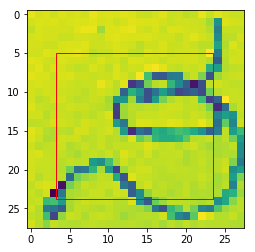

(28, 28)


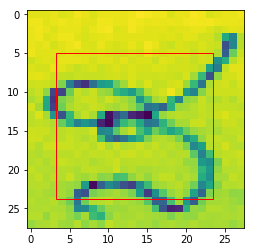

In [25]:
plot_bb(preds)

Save the model

In [26]:
estimator.export_saved_model('saved_model', serving_input_fn)

output_4
Tensor("Conv_s_4/max_pooling2d/MaxPool:0", shape=(?, 12, 12, 16), dtype=float32)
output_3
Tensor("Conv_s_3/re_lu_1/Relu:0", shape=(?, 8, 8, 16), dtype=float32)
output_2
Tensor("Conv_s_2/re_lu_2/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
Printing Output 1
Tensor("Conv_s_1/re_lu_3/Relu:0", shape=(?, 4, 4, 16), dtype=float32)
outut_1_resized bilinear
Tensor("feature_merging_branch/ResizeBilinear:0", shape=(?, 4, 4, 16), dtype=float32)
Concatenation of output_2 and output_1_resized
Tensor("feature_merging_branch/concatenate/concat:0", shape=(?, 4, 4, 32), dtype=float32)
Tensor("feature_merging_branch/Conv_5_1/re_lu_5/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
output_3_resized
Tensor("feature_merging_branch/Conv_5_1/ResizeBilinear:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_6_1/re_lu_7/Relu:0", shape=(?, 2, 2, 16), dtype=float32)
Tensor("feature_merging_branch/Conv_7_1/re_lu_9/Relu:0", shape=(?, 2, 2, 16), dtype=float32)


b'saved_model/1563178505'

In [0]:
#To export files from google drive to google ml bucket
#!gsutil cp '/gdrive/My Drive/indic2019/Test/*.tfrecord' 'gs://indic2019/indic2019'
  

In [27]:
print(tf.__version__)

1.14.0
